Text(0, 0.5, '[Ca2+]')

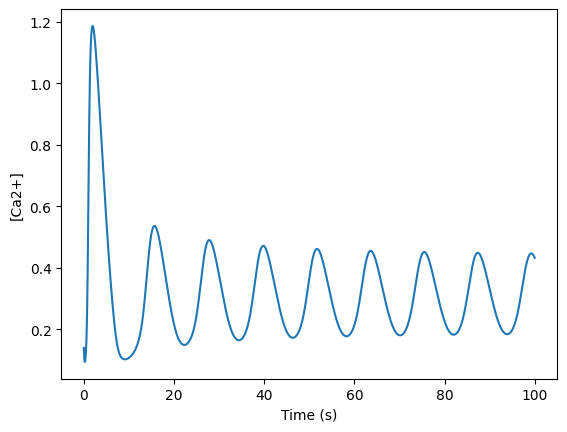

In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

c1 = 0.185
c0 = 2
nu1 = 6
nu2 = 0.11
nu3 = 0.9
k3 = 0.1

a1 = 400
a2 = 0.2
a3 = 400
a4 = 0.2
a5 = 20

d1 = 0.13
d2 = 1.049
d3 = 943.4e-3
d4 = 144.5e-3
d5 = 82.34e-3

J1 = lambda C, CER, x110: c1 * (nu1 * x110 ** 3 + nu2) * (CER - C)
J2 = lambda C: nu3 * C**2 / (C**2 + k3**2)
CER = lambda C: (c0 - C) / c1
dCdt = lambda C, x110: J1(C, CER(C), x110) - J2(C)

def deyoungkeizerode(t, x, P):
    C, x000, x001, x010, x011, x100, x101, x110 = x
    x111 = 1 - x000 - x001 - x010 - x011 - x100 - x101 - x110

    # print(x000 + x001 + x010 + x011 + x100 + x101 + x110 + x111)

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11

    # print(dx000dt + dx001dt + dx010dt + dx011dt + dx100dt + dx101dt + dx110dt + dx111dt)
    # print(sum([x000, x001, x010, x011, x100, x101, x110, x111]))

    return [dCdt(C, x110), dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt]

P = 0.6
t_span = [0, 100]
y0 = [0.14, 1, 0, 0, 0, 0, 0, 0]
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8)
plt.plot(sol.t, sol.y[0])
# for i in range(8):
#     plt.plot(sol.t, sol.y[i])
# plt.xlim(40, 140)
# plt.ylim(0, 0.6)
plt.xlabel('Time (s)')
plt.ylabel('[Ca2+]')
# print(', '.join(list(map(str, sol.y[:, -1]))))

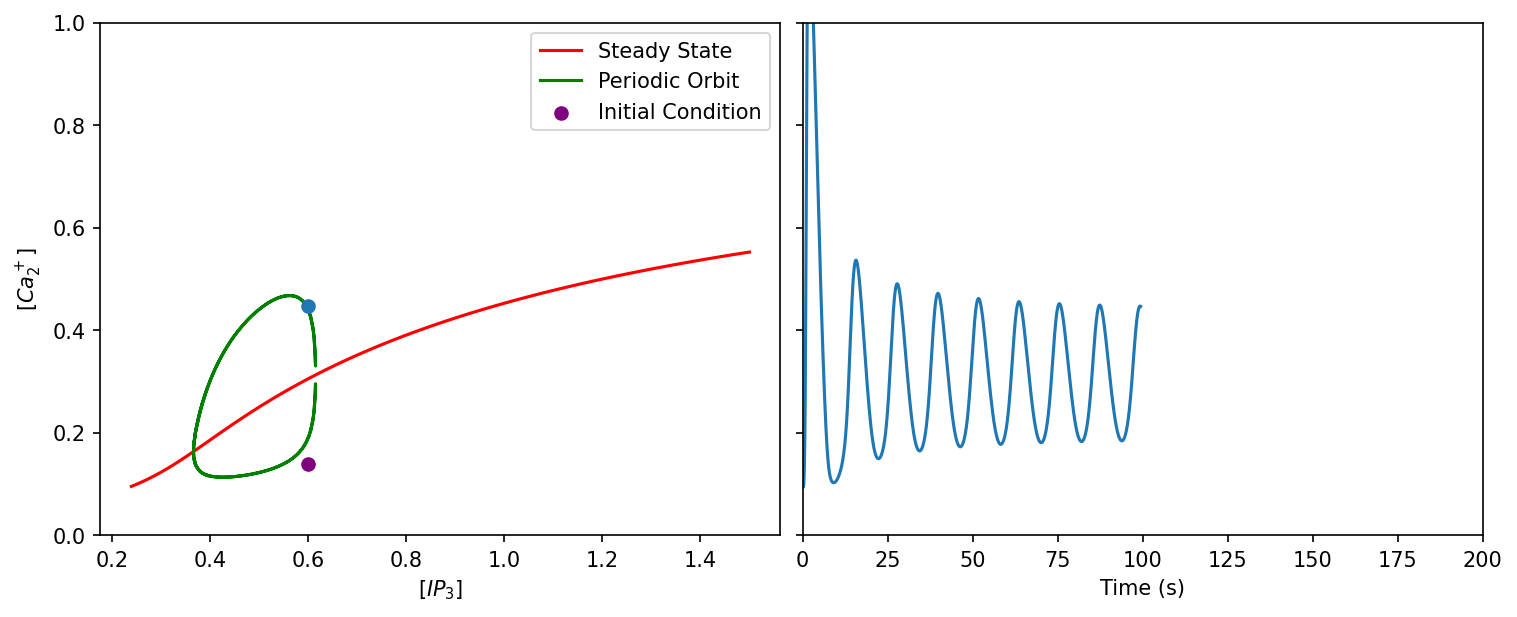

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.dpi'] = 150

fig, axs = plt.subplots(1, 2, sharey=True, layout='constrained', figsize=(10, 4))
ax1 = axs[0]
ax2 = axs[1]
ax1.set_ylabel('$[Ca_2^+]$')
ax1.set_xlabel('$[IP_3]$')

data = pd.read_csv('..\\bifurcation_branch.csv')
periodic = pd.read_csv('..\\periodic_orbits.csv')
ax1.plot(data['P'], data['C'], 'r', label='Steady State')
ax1.plot(periodic['P'], periodic['V_max'], 'g', label='Periodic Orbit')
ax1.plot(periodic['P'], periodic['V_min'], 'g')
ax1.scatter(P, y0[0], color='purple', label='Initial Condition')
ax1.legend()

ax2.set_xlim(0, 200)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Time (s)')

# plt.plot(sol.y[1], sol.y[0])
# plt.plot(np.ones_like(sol.y[0]) * nu4, sol.y[0])
line1, = ax1.plot([], [], 'C0o', label='[$Ca_2^+ (t)$]') # Initial empty plot
line2, = ax2.plot([], [], '-')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def animate(i):
    line1.set_data([P], [sol.y[0][i * 100]])
    line2.set_data(sol.t[:i*100], sol.y[0][:i*100])
    return line1, line2

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t)//100, interval=50, blit=True, repeat=True)
ani.save('basedyk.mp4')

In [30]:
from scipy.optimize import fsolve

def find_steady_state(P, initial_guess=None):
    if initial_guess is None:
        initial_guess = [0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005]
#
    func = lambda x: deyoungkeizerode(0, x, P)
    state = fsolve(func, initial_guess)
    return state

def find_limit_cycle(P, initial_state):
    # (min, max)
    t_span = [0, 200]
    sol = solve_ivp(deyoungkeizerode, t_span, initial_state, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-6)
    return min(sol.y[0][100:]), max(sol.y[0][100:])

def is_hopf(eigvals, prev_eigvals):
    conjugates = eigvals[np.where(np.imag(eigvals) != 0)]
    if conjugates.size == 0:
        return False

    new_real = np.real(conjugates[0])

    conjugates = prev_eigvals[np.where(np.imag(prev_eigvals) != 0)]
    if conjugates.size == 0:
        return False

    prev_real = np.real(conjugates[0])

    # if new_real * prev_real < 0:
    #     print(new_real, prev_real)

    return new_real * prev_real < 0

def frequency(eigvals):
    conjugates = eigvals[np.where(np.imag(eigvals) != 0)]
    return 1 / 2 / np.pi * 1000 * abs(np.imag(conjugates[0]))

HB (0.3727272727272727, 0.16757791222912868) | f = 64.70 Hz
HB (0.6212121212121212, 0.31577606811924147) | f = 87.99 Hz


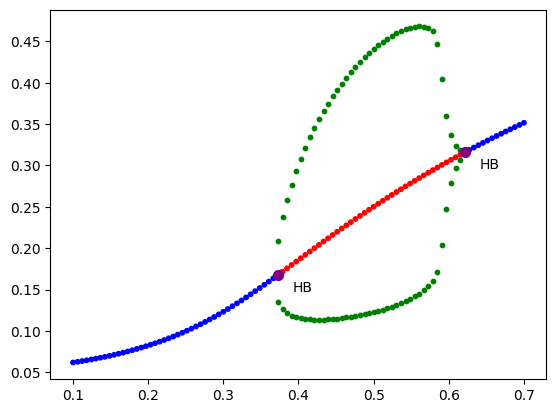

In [31]:
import scipy.differentiate

eps = 1e-10
n_points = 100
Ps = np.linspace(0.1, 0.7, n_points)
stabilities = np.zeros_like(Ps)
states = np.zeros((8, n_points))
prev_eigvals = np.zeros(8)
marker_size = 10

for i, P in enumerate(Ps):
    # print(i)
    if i == 0:
        guess = [0.35153765614145677, 0.017867877002622323, 0.04345427064541731, 0.07628419849862714, 0.18552153610183472, 0.09621165265182983, 0.032242972065326996, 0.41076109991665005]
    else:
        guess = states[:, i - 1]

    new_state = find_steady_state(P, guess)
    eigvals = np.linalg.eigvals(scipy.differentiate.jacobian(lambda x: deyoungkeizerode(0, x, P), new_state).df)
    stable = max(eigvals) < eps

    if not stable:
        bounds = find_limit_cycle(P, guess)
        plt.scatter(P, bounds[0], c='g', s=marker_size)
        plt.scatter(P, bounds[1], c='g', s=marker_size)

    if is_hopf(eigvals, prev_eigvals):
        plt.scatter(P, new_state[0], c='purple', s=marker_size * 5, zorder=2)
        plt.text(P + 0.02, new_state[0] - 0.02, 'HB')
        print(f'HB ({P:.3f}, {new_state[0]:.3f}) | f = {frequency(eigvals):.2f} Hz')

    states[:, i] = new_state
    stabilities[i] = stable
    prev_eigvals = eigvals

colors = ['blue' if stable else 'red' for stable in stabilities]
plt.scatter(Ps, states[0], c=colors, s=marker_size)
# plt.legend()